(-3.77840052992097, 0.0031362000729911344, 9, 17, {'1%': -3.889265672705068, '5%': -3.0543579727254224, '10%': -2.66698384083045}, 29.67310646995882)
Windspeed is (hours) stationary? False


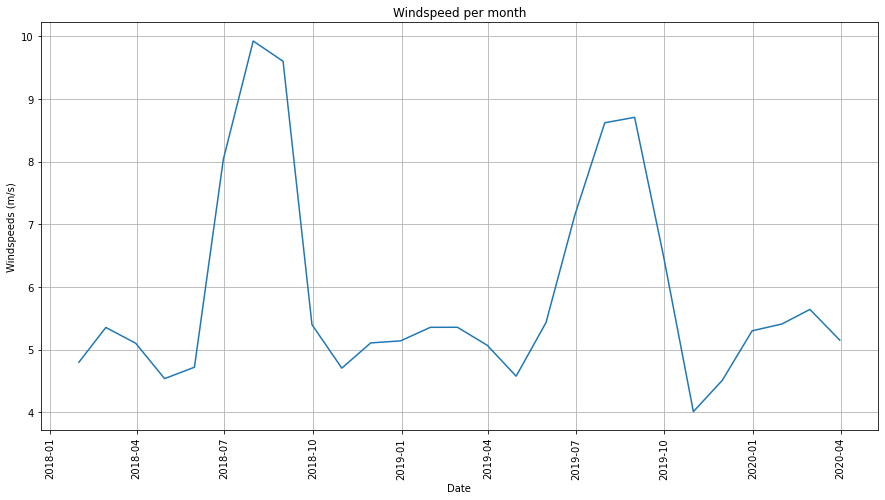

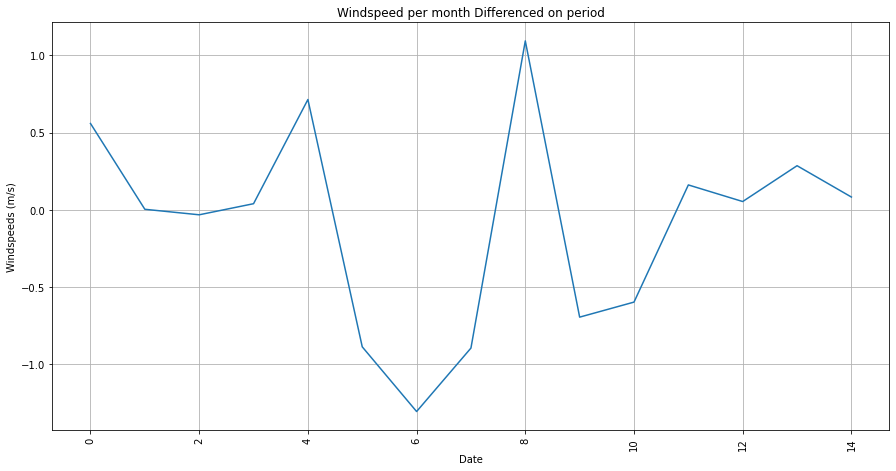

(-5.992597490965517, 1.7313705466709735e-07, 43, 15971, {'1%': -3.430759514203331, '5%': -2.8617209883703265, '10%': -2.566866335600857}, 219307.72688427768)
Windspeed is (hours) stationary? True


AttributeError: 'list' object has no attribute 'shape'

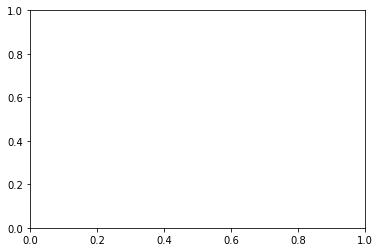

In [3]:
from itertools import product
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

data = pd.read_csv("Cleaned_data.csv")
subset = data[["Unnamed: 0", "ActivePower", "WindSpeed", "WindDirection"]]

# convert Datetime to pandas datetimeand set it as index
subset["Unnamed: 0"] = pd.to_datetime(subset["Unnamed: 0"], format="%Y-%m-%d %H:%M:%S")
datetime_index = pd.DatetimeIndex(subset["Unnamed: 0"].values)
subset = subset.set_index(datetime_index)
# Drop redundant column
subset = subset.drop(['Unnamed: 0'], axis=1)

# Autoregression plots
windspeeds_days = subset['WindSpeed'].resample('D').mean()
windspeeds_weeks = subset['WindSpeed'].resample('W').mean()
windspeeds_months = subset['WindSpeed'].resample('M').mean()
windspeeds_days = windspeeds_days.dropna()
windspeeds_weeks = windspeeds_weeks.dropna()
windspeeds_hours = subset['ActivePower']



# Dickley Fuller test
results_windspeeds_months = adfuller(windspeeds_months, autolag="AIC")
print(results_windspeeds_months)
# So as expected, the windspeed is seasonal for the months, but not when taking into account
print("Windspeed is (hours) stationary?", results_windspeeds_months[0] < results_windspeeds_months[4]['1%'])

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(windspeeds_months)
plt.title('Windspeed per month')
plt.ylabel('Windspeeds (m/s)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

windspeeds_months = difference(windspeeds_months, 12)
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(windspeeds_months)
plt.title('Windspeed per month Differenced on period')
plt.ylabel('Windspeeds (m/s)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Dickley Fuller test
results_windspeeds_months = adfuller(windspeeds_hours, autolag="AIC")
print(results_windspeeds_months)
# So as expected, the windspeed is seasonal for the months, but not when taking into account
print("Windspeed is (hours) stationary?", results_windspeeds_months[0] < results_windspeeds_months[4]['1%'])

# Autoregression plots
plot_acf(windspeeds_months )
plot_pacf(windspeeds_months)
plt.show()

def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

# Note that we will only test different values for the parameters p, P, q and Q.
# We know that both seasonal and non-seasonal integration parameters should be 1,
# and that the length of the season is 24 hours.
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, 1, 1, 24, windspeeds_months)
result_df
